### Environment Setup
Run this cell to install the necessary libraries if they are not already installed.

In [49]:
!pip install pandas numpy matplotlib seaborn scikit-learn

### Library and Dataset Imports

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB         
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_curve, auc, f1_score)
import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

print(df['label'].value_counts())

df.head()

label
1    134850
0    100945
Name: count, dtype: int64


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


### Data Cleaning and Preprocessing
Metadata columns (`FILENAME`, `URL`, `Domain`, `Title`) were removed, and the categorical `TLD` column was encoded into numeric values.

In [52]:
cols_to_drop = ['FILENAME', 'URL', 'Domain', 'Title']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

if 'TLD' in df_clean.columns:
    le = LabelEncoder()
    df_clean['TLD'] = le.fit_transform(df_clean['TLD'].astype(str))
    print("TLD column encoded.")

print(f"Shape after cleaning: {df_clean.shape}")

TLD column encoded.
Shape after cleaning: (235795, 52)


### Correlation Analysis and Feature Selection
Feature relationships were visualized using a heatmap, and features with a correlation higher than 0.75 were removed to prevent multicollinearity.

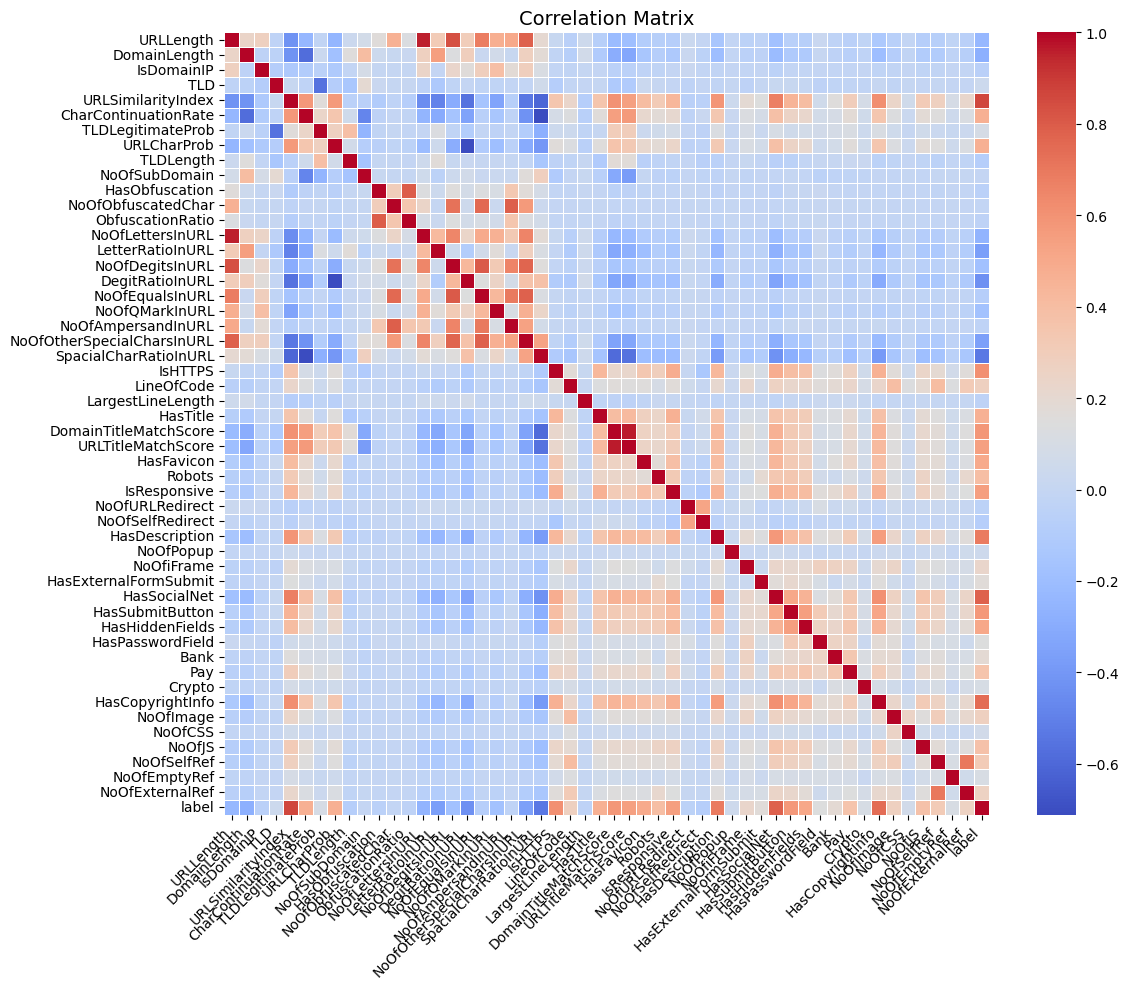

Dropped features: 

ObfuscationRatio
NoOfLettersInURL
NoOfDegitsInURL
NoOfEqualsInURL
NoOfEqualsInURL
NoOfAmpersandInURL
NoOfOtherSpecialCharsInURL
NoOfOtherSpecialCharsInURL
NoOfOtherSpecialCharsInURL
URLTitleMatchScore

Remaining features count: 45


In [53]:
subset_df = df_clean.iloc[:, :] 
corr_matrix = subset_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=False, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=0.5, 
            square=False, 
            annot_kws={"size": 8})

plt.title('Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 
plt.savefig("1_correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

df_reduced = df_clean.copy()
threshold = 0.75 

print("Dropped features: \n")
for step in range(3): 
    correlation_matrix = df_reduced.corr('pearson').abs()
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if i != j and abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                if colname != "label": 
                    print(colname)
                    correlated_features.add(colname)
    
    if len(correlated_features) > 0:
        df_reduced = df_reduced.drop(columns=correlated_features, errors='ignore')
    else:
        break

print(f"\nRemaining features count: {df_reduced.shape[1]}")

df = df_reduced

### Data Splitting and Scaling
The `URLSimilarityIndex` column was dropped, and duplicate records were removed. The dataset was split into training and testing sets, and standard scaling was applied.

In [54]:
if 'URLSimilarityIndex' in df.columns:
    df = df.drop(columns=['URLSimilarityIndex'])

if df.duplicated().sum() > 0:
    df = df.drop_duplicates()

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Training Set Shape: {X_train_scaled.shape}")
print(f"Test Set Shape: {X_test_scaled.shape}")

Training Set Shape: (187720, 43)
Test Set Shape: (46930, 43)


### Dummy Classifier Model Training

In [55]:
print("Dummy Classifier")
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred_dummy))

Dummy Classifier
Baseline Accuracy: 0.5746857021095249


### Logistic Regression Model Training

In [56]:
print("Logistic Regression:")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_log, digits=5))

Logistic Regression:
              precision    recall  f1-score   support

           0    0.99940   0.99865   0.99902     19960
           1    0.99900   0.99956   0.99928     26970

    accuracy                        0.99917     46930
   macro avg    0.99920   0.99910   0.99915     46930
weighted avg    0.99917   0.99917   0.99917     46930



### KNN (K-Nearest Neighbors) Model Training

In [57]:
print("KNN (K-Nearest Neighbors):")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn, digits=5))

KNN (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0    0.99884   0.99594   0.99739     19960
           1    0.99700   0.99915   0.99807     26970

    accuracy                        0.99778     46930
   macro avg    0.99792   0.99754   0.99773     46930
weighted avg    0.99779   0.99778   0.99778     46930



### Gaussian Naive Bayes Model Training

In [58]:
print("Gaussian Naive Bayes:")
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_nb, digits=5))

Gaussian Naive Bayes:
              precision    recall  f1-score   support

           0    0.99897   0.87360   0.93209     19960
           1    0.91440   0.99933   0.95498     26970

    accuracy                        0.94586     46930
   macro avg    0.95669   0.93646   0.94353     46930
weighted avg    0.95037   0.94586   0.94524     46930



### Random Forest Model Training

In [59]:
print("Random Forest: ")
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train_scaled, y_train) 
y_pred_rf = rf_clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf, digits=5))

Random Forest: 
              precision    recall  f1-score   support

           0    1.00000   0.99965   0.99982     19960
           1    0.99974   1.00000   0.99987     26970

    accuracy                        0.99985     46930
   macro avg    0.99987   0.99982   0.99985     46930
weighted avg    0.99985   0.99985   0.99985     46930



### Model Training and Hyperparameter Tuning
Hyperparameter tuning was performed using GridSearchCV to optimize the Random Forest classifier.

In [60]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

rf_clf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

y_pred_rf = rf_clf.predict(X_test_scaled)
y_prob_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_rf, digits=5))

Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0    0.99990   0.99960   0.99975     19960
           1    0.99970   0.99993   0.99981     26970

    accuracy                        0.99979     46930
   macro avg    0.99980   0.99976   0.99978     46930
weighted avg    0.99979   0.99979   0.99979     46930



### Model Comparison
The accuracy scores of Logistic Regression, KNN, Naive Bayes, and Random Forest models were calculated. The results were tabulated and visualized using a bar chart to compare performance.

                 Model  Accuracy
3        Random Forest  0.999787
0  Logistic Regression  0.999169
1                  KNN  0.997784
2          Naive Bayes  0.945856


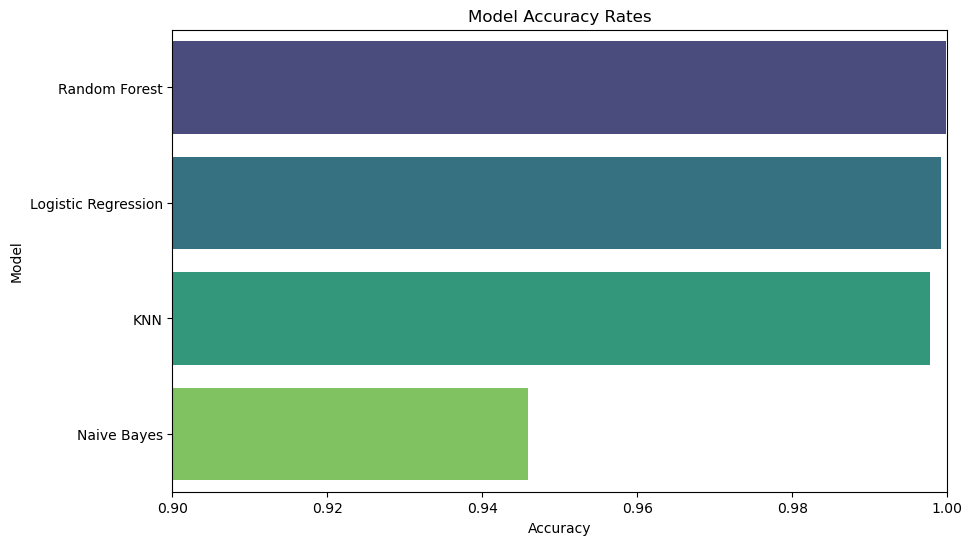

In [61]:
models = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log),
    'KNN': accuracy_score(y_test, y_pred_knn),
    'Naive Bayes': accuracy_score(y_test, y_pred_nb),
    'Random Forest': accuracy_score(y_test, y_pred_rf)
}

results_df = pd.DataFrame(list(models.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Rates')
plt.xlim(0.90, 1.0) 
plt.savefig("2_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrix Analysis
Confusion matrices were generated for each model to evaluate classification performance.

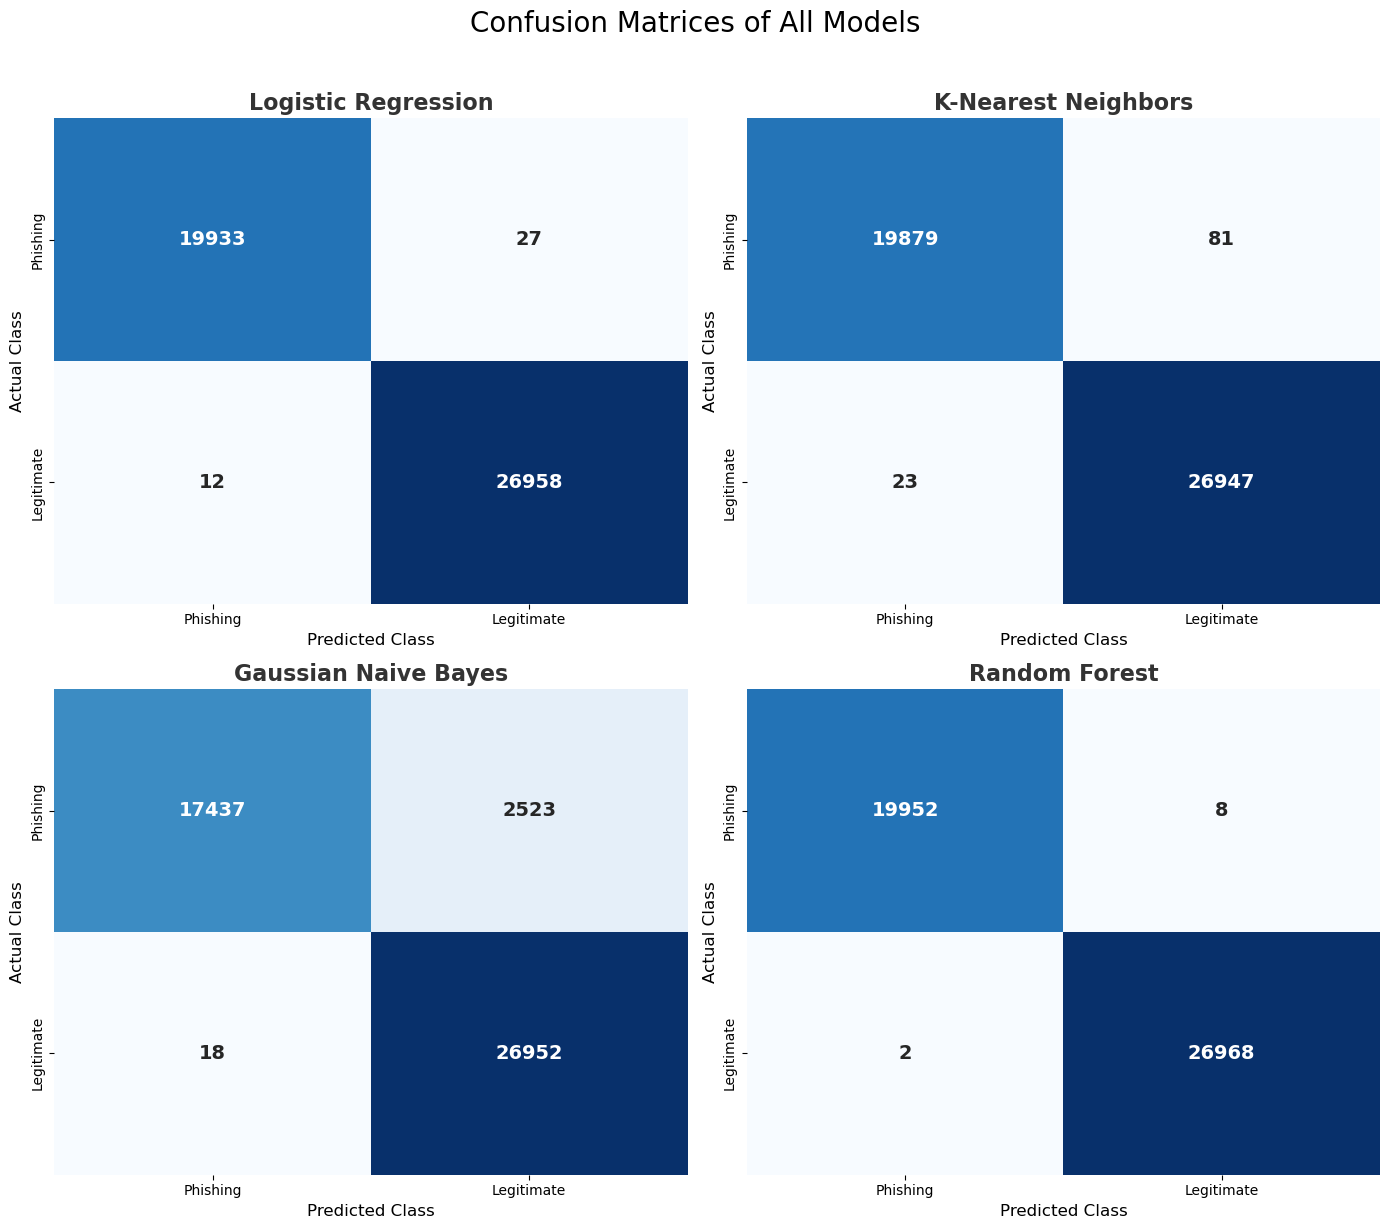

In [62]:
models_list = [log_reg, knn, nb, rf_clf]
model_names = ["Logistic Regression", "K-Nearest Neighbors", "Gaussian Naive Bayes", "Random Forest"]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

class_labels = ['Phishing', 'Legitimate']

for i, model in enumerate(models_list):
    y_pred = model.predict(X_test_scaled)
    
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_labels, yticklabels=class_labels,
                annot_kws={"size": 14, "weight": "bold"}, cbar=False)
    
    axes[i].set_title(f"{model_names[i]}", fontsize=16, fontweight='bold', color='#333333')
    axes[i].set_ylabel('Actual Class', fontsize=12)
    axes[i].set_xlabel('Predicted Class', fontsize=12)

plt.suptitle("Confusion Matrices of All Models", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("3_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

### ROC Curve Analysis
ROC curves were generated to evaluate the diagnostic ability of the classifiers.

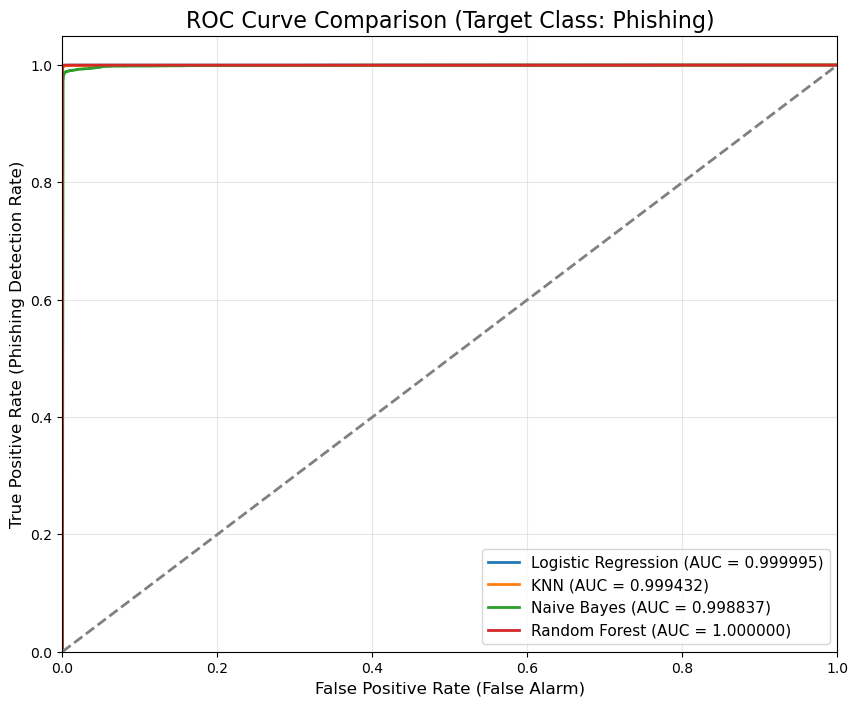

In [63]:
models_list = [log_reg, knn, nb, rf_clf]
model_names = ["Logistic Regression", "KNN", "Naive Bayes", "Random Forest"]

plt.figure(figsize=(10, 8))

for i, model in enumerate(models_list):
    name = model_names[i]
    X_current = X_test_scaled
        
    y_scores = model.predict_proba(X_current)[:, 0]
    
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label=0)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.6f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarm)', fontsize=12)
plt.ylabel('True Positive Rate (Phishing Detection Rate)', fontsize=12)
plt.title('ROC Curve Comparison (Target Class: Phishing)', fontsize=16)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

plt.savefig("4_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

### Feature Importance Analysis
Top 15 most important features extracted from the Random Forest model.

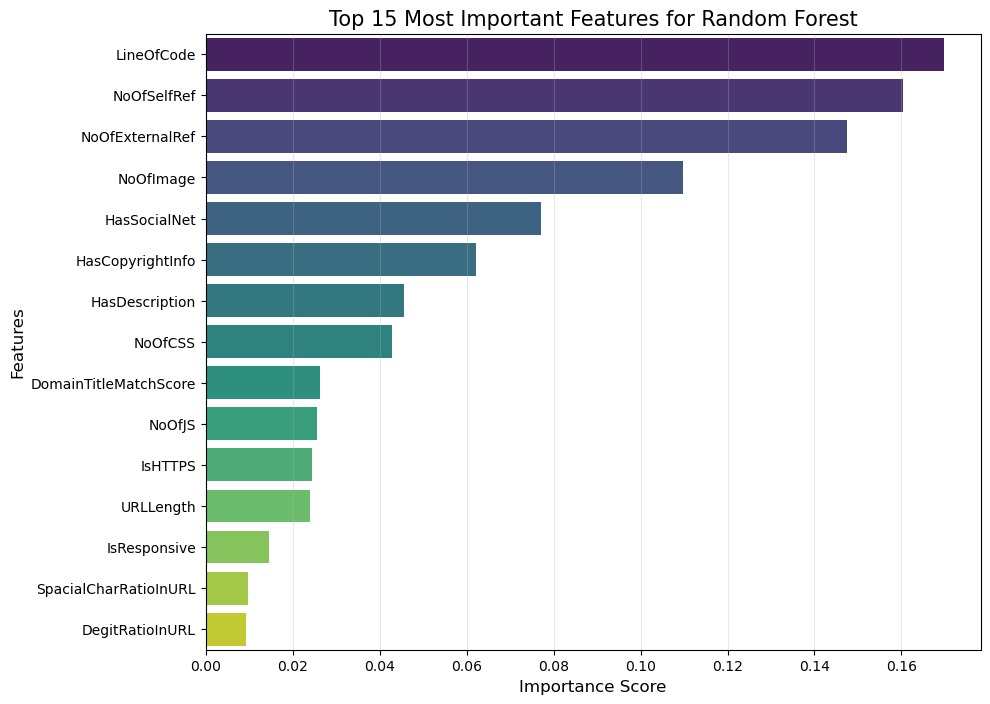

Top 5 Features:
            Feature  Importance
16       LineOfCode    0.169720
40      NoOfSelfRef    0.160392
42  NoOfExternalRef    0.147538
37        NoOfImage    0.109673
29     HasSocialNet    0.077032


In [64]:
importances = rf_clf.feature_importances_
feature_names = X.columns # Sütun isimleri
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

plt.title('Top 15 Most Important Features for Random Forest', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.savefig("5_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print("Top 5 Features:")
print(feature_imp_df.head(5))

### Error Analysis
The distribution of misclassified samples was analyzed to understand why the model failed in specific cases.

Feature: LineOfCode
  - Detected Phishing (TP) Median: 11.0
  - Missed Phishing (FN) Median:   512.0
  - False Alarm (FP) Median:       131.5
Feature: NoOfSelfRef
  - Detected Phishing (TP) Median: 0.0
  - Missed Phishing (FN) Median:   7.5
  - False Alarm (FP) Median:       2.5


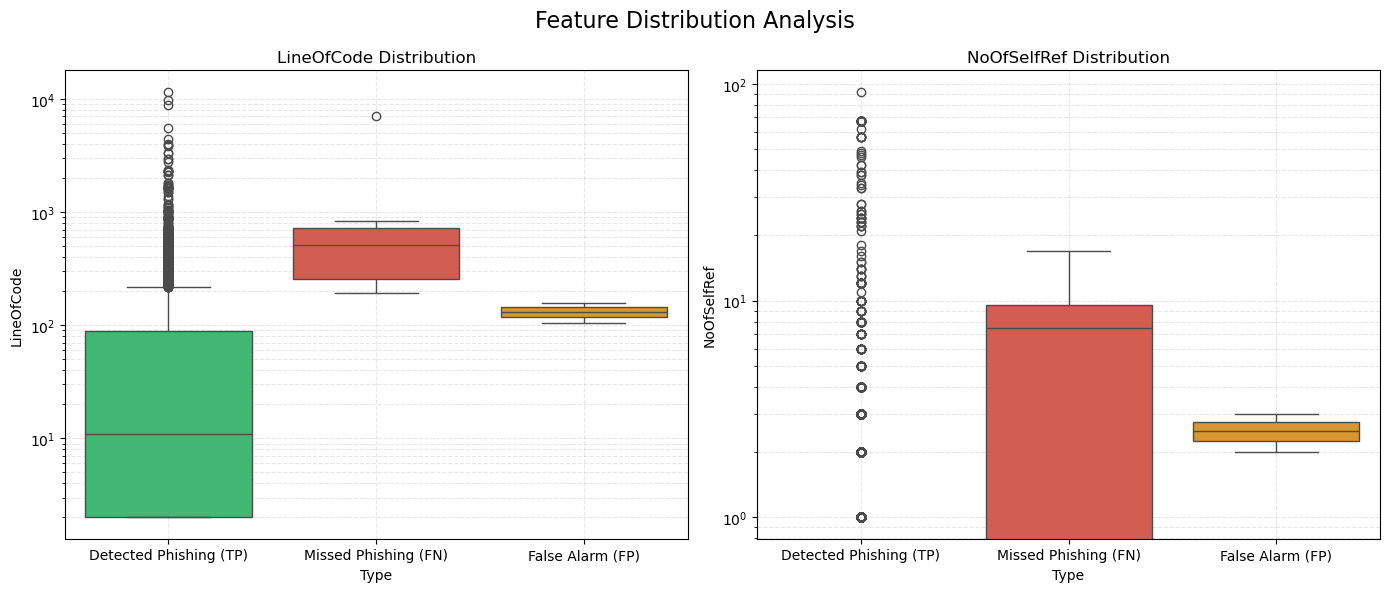

In [65]:
y_pred_best = rf_clf.predict(X_test_scaled)

fn_mask = (y_test == 0) & (y_pred_best == 1)
fp_mask = (y_test == 1) & (y_pred_best == 0) 
tp_mask = (y_test == 0) & (y_pred_best == 0) 

X_fn = X_test[fn_mask]
X_fp = X_test[fp_mask]
X_tp = X_test[tp_mask]

top_2_features = feature_imp_df['Feature'].iloc[:2].values 

for feat in top_2_features:
    val_tp = X_tp[feat].median()
    val_fn = X_fn[feat].median()
    print(f"Feature: {feat}")
    print(f"  - Detected Phishing (TP) Median: {val_tp}")
    print(f"  - Missed Phishing (FN) Median:   {val_fn}")
    if len(X_fp) > 0:
        print(f"  - False Alarm (FP) Median:       {X_fp[feat].median()}")

plt.figure(figsize=(14, 6))

for i, feature in enumerate(top_2_features):
    plt.subplot(1, 2, i+1)
    
    # Veriyi Hazırla
    data_pieces = [X_tp[feature], X_fn[feature]]
    labels = ['Detected Phishing (TP)', 'Missed Phishing (FN)']
    palette = ['#2ecc71', '#e74c3c'] # Yeşil, Kırmızı
    
    if len(X_fp) > 0:
        data_pieces.append(X_fp[feature])
        labels.append('False Alarm (FP)')
        palette.append('#f39c12') # Turuncu

    plot_data = pd.DataFrame({
        feature: pd.concat(data_pieces),
        'Type': np.concatenate([[label] * len(data) for label, data in zip(labels, data_pieces)])
    })
    
    # Çizim
    sns.boxplot(x='Type', y=feature, data=plot_data, palette=palette)
    
    plt.yscale('log') 
    
    plt.title(f'{feature} Distribution', fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.ylabel(f"{feature}")

plt.suptitle("Feature Distribution Analysis", fontsize=16)
plt.tight_layout()
plt.savefig("6_error_analysis.png", dpi=300, bbox_inches='tight')
plt.show()